In [8]:
from tensorflow.keras.layers import Input, Add, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.models import Model
from datasets import load_dataset
import cv2
import numpy as np
import os
from multiprocessing import Pool
from tensorflow.keras.regularizers import l2

from IPython.display import clear_output
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import random,os,glob
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mp
import random
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight



In [ ]:
path = '/kaggle/input/minc2500/minc-2500/images/'

In [3]:
import shutil
source_dir = "/kaggle/input/minc2500/minc-2500/images"
selected_classes = ['plastic', 'glass', 'metal', 'wood', 'paper']
new_dir = "/kaggle/working/selected_images"

os.makedirs(new_dir, exist_ok=True)

for class_name in selected_classes:
    class_dir = os.path.join(source_dir, class_name)
    if os.path.isdir(class_dir):
        shutil.copytree(class_dir, os.path.join(new_dir, class_name))



NameError: name 'splitfolders' is not defined

In [7]:
import splitfolders
splitfolders.ratio(new_dir, output="/kaggle/working/Splitted", seed=1337, ratio=(0.65, 0.2, 0.15))

print("Selected classes have been split into train, validation, and test sets.")

Copying files: 12500 files [00:01, 6451.25 files/s]

Selected classes have been split into train, validation, and test sets.


In [9]:
train_path = '/kaggle/input/trashdata/train/'
val_path = '/kaggle/input/trashdata/val/'
test_path = '/kaggle/input/trashdata/test/'

In [27]:
image_size = (224, 224)
batch_size = 64


train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)


val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    batch_size=64, 
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size= 506, 
    class_mode='categorical',
    shuffle=False
)

Found 4043 images belonging to 6 classes.
Found 505 images belonging to 6 classes.
Found 506 images belonging to 6 classes.


In [120]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

img_input = (224, 224, 3)  


DenseNet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=img_input)

for layer in DenseNet_base.layers:
    layer.trainable = False
for layer in DenseNet_base.layers[-200:]:
    layer.trainable = True

model_DenseNet = Sequential()

model_DenseNet.add(DenseNet_base)
model_DenseNet.add(GlobalAveragePooling2D())


model_DenseNet.add(Dense(512, activation='relu'))  
model_DenseNet.add(Dropout(0.5))

model_DenseNet.add(Dense(512, activation='relu'))
model_DenseNet.add(Dropout(0.5))



model_DenseNet.add(Dense(256, activation='relu'))



model_DenseNet.add(Dense(6, activation='softmax'))  




In [121]:
optimizer = Adam(learning_rate=0.0001)
model_DenseNet.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [122]:
print(model_DenseNet.summary())

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 4,403,584 (16.80 MB)

 Non-trainable params: 2,633,920 (10.05 MB)

None


In [123]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model_DenseNet.fit(
    train_generator,
    epochs=100,  
    validation_data=val_generator,
    validation_steps=val_generator.samples,
    callbacks=[early_stopping]
)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.3441 - loss: 1.6437 - val_accuracy: 0.6673 - val_loss: 0.9009
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 649ms/step - accuracy: 0.6870 - loss: 0.8563 - val_accuracy: 0.8218 - val_loss: 0.4895
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 637ms/step - accuracy: 0.8139 - loss: 0.5343 - val_accuracy: 0.8139 - val_loss: 0.5131
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 645ms/step - accuracy: 0.8781 - loss: 0.3732 - val_accuracy: 0.9050 - val_loss: 0.2676
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 654ms/step - accuracy: 0.9137 - loss: 0.2517 - val_accuracy: 0.9208 - val_loss: 0.2631
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 654ms/step - accuracy: 0.9391 - loss: 0.1842 - val_accuracy: 0.9386 - val_loss: 0.2076
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 647ms/step - accuracy: 0.9507 - loss: 0.1424 - val_accuracy: 0.9208 - val_loss: 0.2253
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 644ms/step - accuracy: 0.9605 - loss: 0.1227 - va

In [124]:
model_DenseNet.save("model_denseNetFinal.h5")

In [125]:
model_DenseNet.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9710 - loss: 0.1481 


[0.19232119619846344, 0.9683794379234314]

In [4]:
from tensorflow.keras.models import load_model

model_DenseNet= load_model("/kaggle/working/model_denseNetFinal.h5")

In [28]:
y_pred_probs = model_DenseNet.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1) 
y_true = test_generator.classes

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step


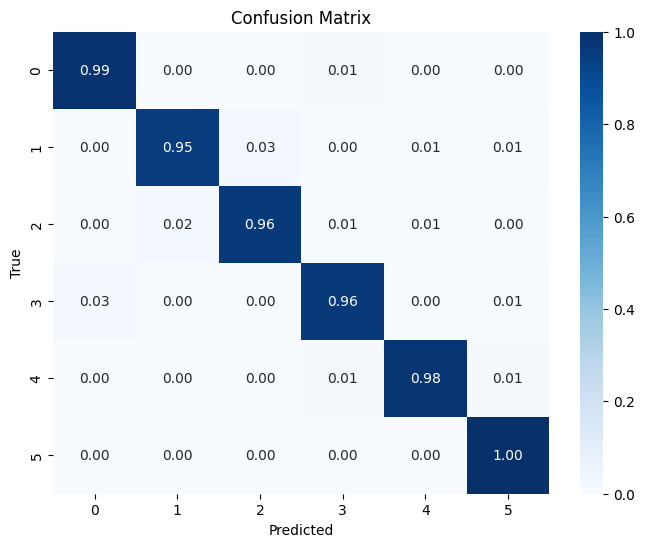

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

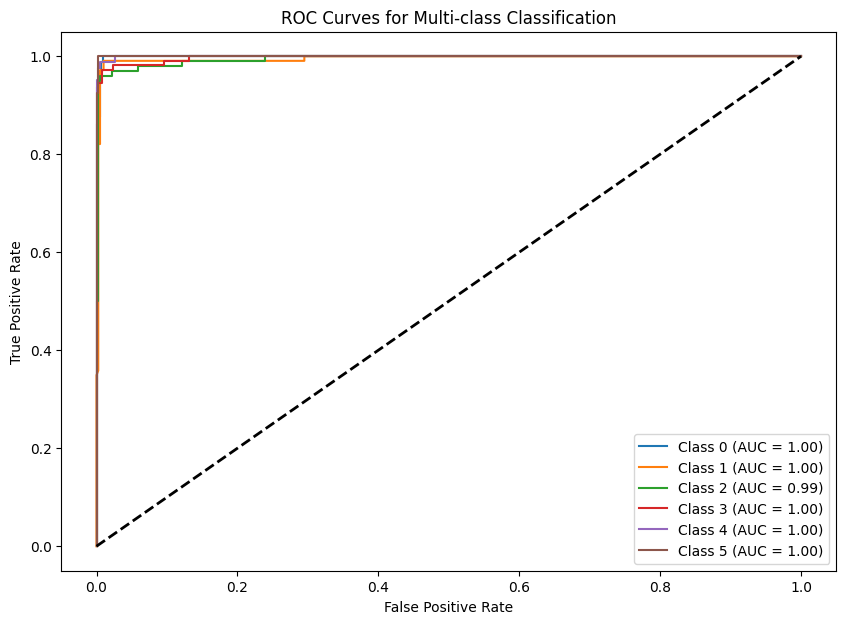

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import numpy as np


n_classes = len(set(y_true)) 
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np


n_classes = len(set(y_true))  

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
auc = roc_auc_score(y_true_bin, y_pred_probs, average='weighted', multi_class='ovr')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Precision: 0.9689
Recall: 0.9684
F1-Score: 0.9684
AUC: 0.9971
